In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
from typing import List, Tuple
from adabmDCA.fasta_utils import get_tokens
from adabmDCA.utils import resample_sequences
import h5py

import torch
from annadca.categorical import annaRBMcat
from annadca.dataset import DatasetCat
from annadca.utils import get_eigenvalues_history
from annadca.plot import plot_PCA

### Plot the results

In [2]:
fname_data = "/home/rosset/data/PF00072/PF00072.fasta"
fname_ann = "/home/rosset/data/PF00072/PF00072_ann.csv"
fname_weights = "/home/rosset/data/PF00072/PF00072_weights.dat"
fname_chains = "/home/rosset/models/PF00072/annaDCA_chains.fasta"
fname_model = "/home/rosset/models/PF00072/annaDCA_params.h5"

#fname_data = "/home/rosset/data/Test/SAM/SAM.fasta"
#fname_ann = "/home/rosset/data/Test/SAM/SAM_ann.csv"
#fname_weights = None
#fname_chains = "/home/rosset/models/SAM/annaDCA_chains.fasta"
#fname_model = "/home/rosset/models/SAM/annaDCA_params.h5"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

In [4]:
tokens = get_tokens("protein")
rbm = annaRBMcat()
dataset = DatasetCat(
    path_data=fname_data,
    path_labels=fname_ann,
    path_weights=fname_weights,
    alphabet=tokens,
    device=device,
)

data_flat = dataset.data_one_hot.view(len(dataset.data), -1)
weights = dataset.weights.view(-1)
labels_data = dataset.to_label(dataset.labels_one_hot)

chains = rbm.load_chains(filename=fname_chains, alphabet=tokens, device=device, dtype=dtype)
labels_chains = dataset.to_label(chains["label"])

Multi-sequence alignment imported: M = 49527, L = 112, q = 21, M_eff = 42985.


In [5]:
# project data and chains
_, _, Vt = torch.linalg.svd(data_flat - data_flat.mean(0), full_matrices=False)
data_proj = data_flat @ Vt.T / dataset.get_num_residues()**0.5
chains_proj = chains["visible"].view(len(chains["visible"]), -1) @ Vt.T / dataset.get_num_residues()**0.5
data_proj = data_proj.cpu().numpy()
chains_proj = chains_proj.cpu().numpy()

/tmp/ipykernel_2882/3389677633.py:2: UserWarning: torch.linalg.svd: During SVD computation with the selected cusolver driver, batches 0 failed to converge. A more accurate method will be used to compute the SVD as a fallback. Check doc at https://pytorch.org/docs/stable/generated/torch.linalg.svd.html (Triggered internally at ../aten/src/ATen/native/cuda/linalg/BatchLinearAlgebraLib.cpp:697.)
  _, _, Vt = torch.linalg.svd(data_flat - data_flat.mean(0), full_matrices=False)


In [6]:
# Define the colors
unique_labels = np.unique(labels_data)
cmap = plt.get_cmap("tab10", len(unique_labels))
label_to_color = {label.item(): cmap(i) for i, label in enumerate(unique_labels)}

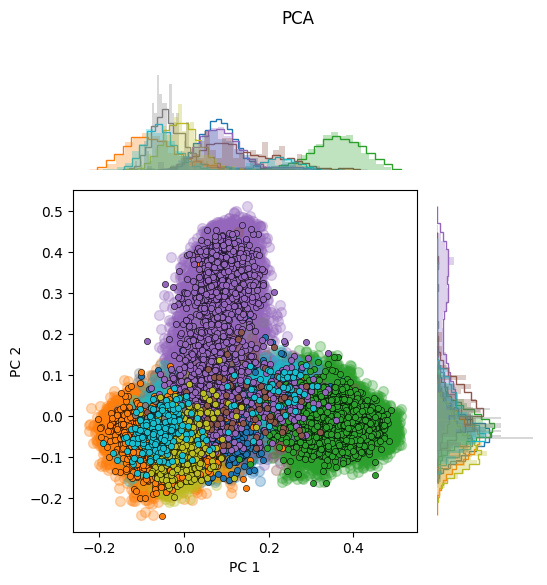

In [11]:
fig = plt.figure(figsize=(6,6))
fig = plot_PCA(
    fig=fig,
    data1=data_proj,
    labels1=labels_data,
    data2=chains_proj,
    labels2=labels_chains,
    label_to_color=label_to_color,
    dim1=0,
    dim2=1,
    title="PCA",
    split_labels=True,
)


In [13]:
updates, eigenvalues = get_eigenvalues_history(fname_model, target_matrix="weight_matrix", device=device, dtype=dtype)
updates, eigenvalues_labels = get_eigenvalues_history(fname_model, target_matrix="label_matrix", device=device, dtype=dtype)

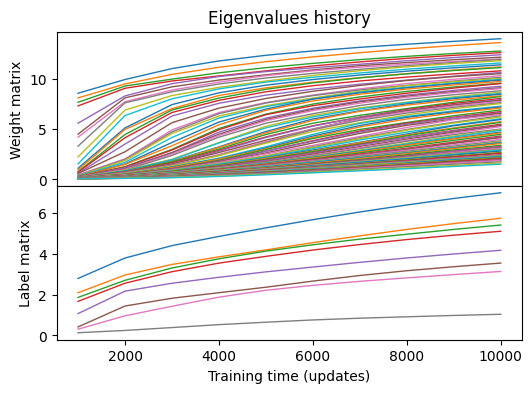

In [14]:
# Plot the eigenvalues history. first row is the weight matrix, second row is the label matrix. xaxis is shared and there is no border between the plots
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True, gridspec_kw={'hspace': 0})
ax[0].plot(updates, eigenvalues, lw=1)
ax[1].plot(updates, eigenvalues_labels, lw=1)
ax[1].set_xlabel("Training time (updates)")
ax[0].set_ylabel("Weight matrix")
ax[1].set_ylabel("Label matrix")
#ax[0].set_xscale("log")
#ax[1].set_yscale("log")
#ax[0].set_yscale("log")
ax[0].set_title("Eigenvalues history");

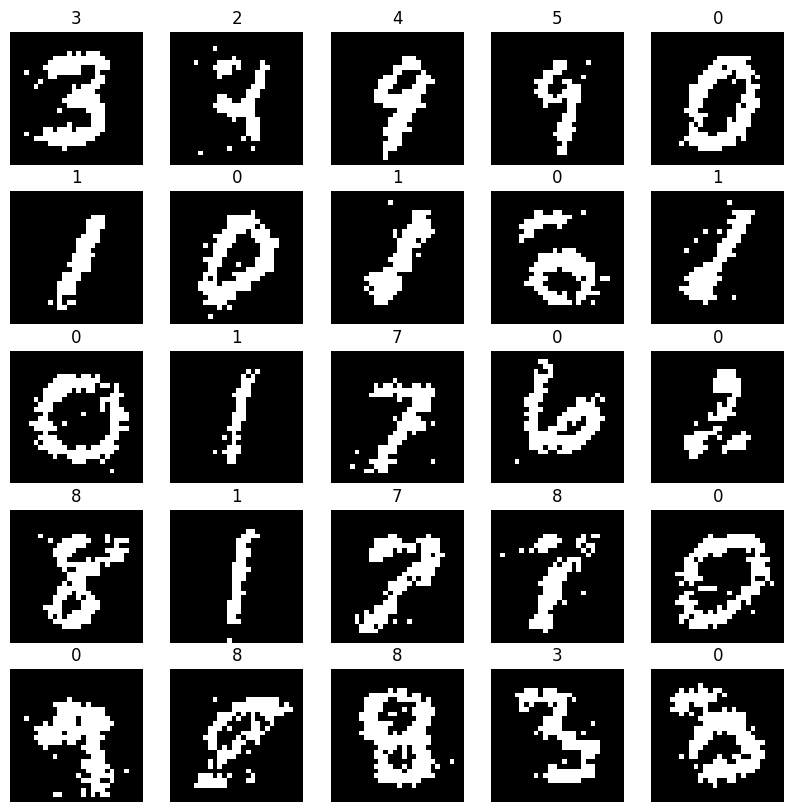

In [ ]:
# Visualize the first 25 chains as mnist images with the corresponding labels
l = chains["label"]
first_25_labels = dataset.to_label(l)[:25]
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(chains[i].cpu().numpy().reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(labels_chains[i])

### Conditioned sampling

In [ ]:
rbm.load(fname_model, device=device, dtype=dtype)
init_chains = rbm.init_chains(num_samples=dataset.__len__())
cond_chains = rbm.sample_conditioned(
    gibbs_steps=1000,
    chains=init_chains,
    targets=dataset.labels_one_hot,
)

In [19]:
cond_chains_proj = cond_chains.view(len(cond_chains), -1) @ Vt.T / cond_chains.shape[1]**0.5
cond_chains_labels = labels_data
cond_chains_proj = cond_chains_proj.cpu().numpy()

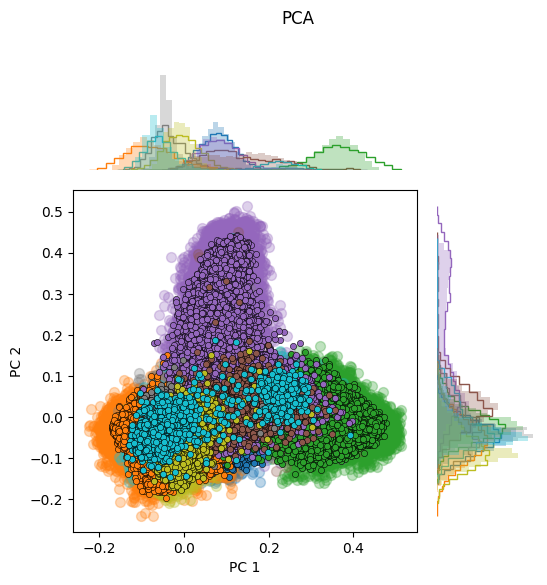

In [20]:
fig = plt.figure(figsize=(6,6))
fig = plot_PCA(
    fig=fig,
    data1=data_proj,
    labels1=labels_data,
    data2=cond_chains_proj,
    labels2=cond_chains_labels,
    label_to_color=label_to_color,
    dim1=0,
    dim2=1,
    title="PCA",
    split_labels=True,
)

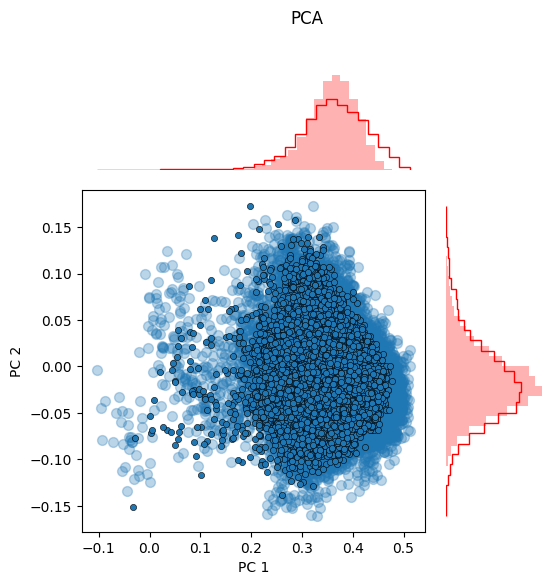

In [21]:
# Plot pca of conditioned chains and data but only one label
label = "PF00486"
mask_data = labels_data == label
mask_gen = cond_chains_labels == label
data_proj_label = data_proj[mask_data]
chains_proj_label = cond_chains_proj[mask_gen]

fig = plt.figure(figsize=(6,6))
fig = plot_PCA(
    fig=fig,
    data1=data_proj_label,
    labels1=labels_data[mask_data],
    data2=chains_proj_label,
    labels2=cond_chains_labels[mask_gen],
    label_to_color={label: cmap(0)},
    dim1=0,
    dim2=1,
    title="PCA",
    split_labels=False,
)

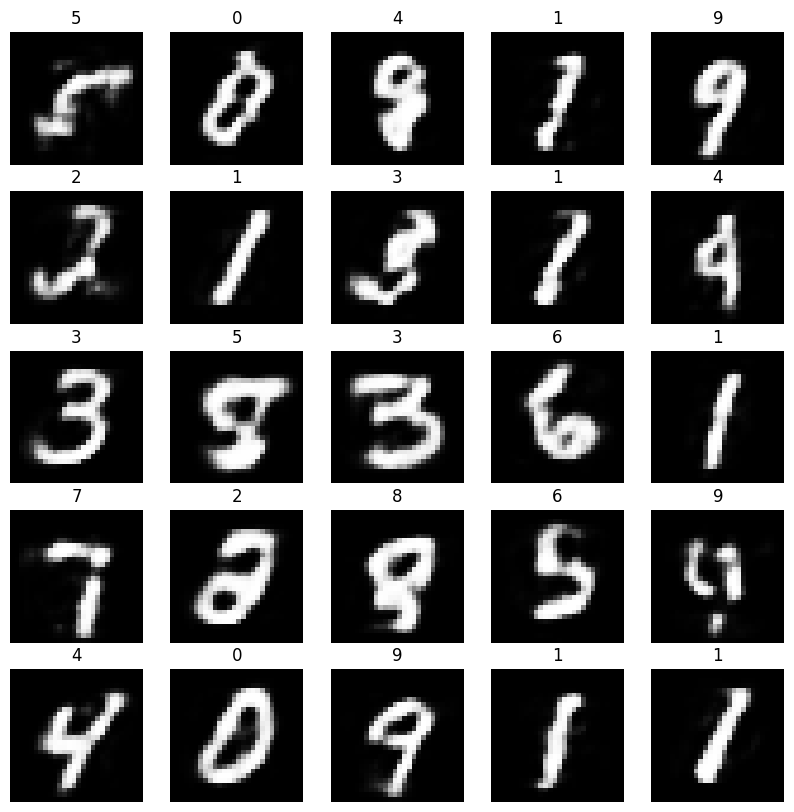

In [17]:
# Visualize the first 25 chains as mnist images with the corresponding labels
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(cond_chains["visible"][i].cpu().numpy().reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(cond_chains_labels[i])

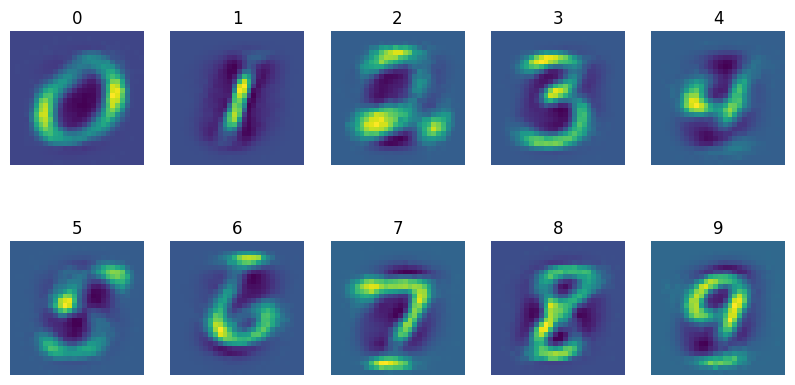

In [ ]:
from annadca.utils import mutual_information
Iil = mutual_information(
    visible=cond_chains,
    label=labels_data,
)

# Plot an image of the mutual information between labels and chains for each label
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(Iil[i].cpu().numpy().reshape(28, 28), cmap='viridis')
    ax.axis('off')
    ax.set_title(i)